# Gaussian Blur with CUDA

CUDA를 활용하여 Gaussian Blur filter의 CUDA 코드를 작성합시다.
필요할 경우 reference_calc.cc를 참고하시면 됩니다.

Image Bluring Filter는 Gaussian filter를 이미지에 적용한 것으로, 특정 위치의 픽셀과 주변 픽셀의 값을 참조하여 이미지를 흐릿하게 만드는 기능을 합니다. Image Convolution이라고도 부릅니다. 아래 그림을 보면 적용 전과 후를 보실 수 있습니다.

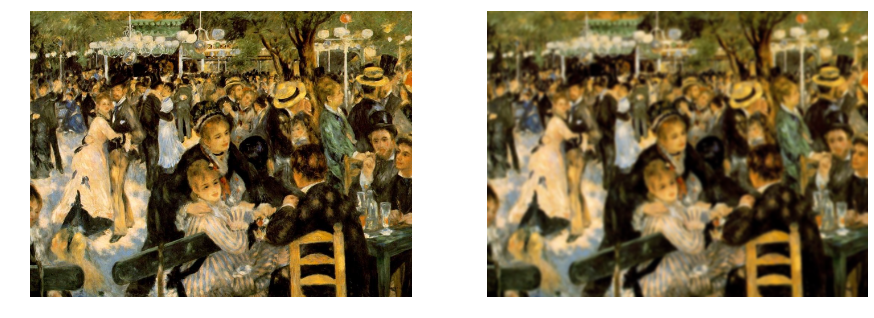

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
fig = plt.figure(figsize=(15,6))

fig.add_subplot(1,2,1)
image = mpimg.imread("image.png")
plt.axis("off")
plt.imshow(image)

fig.add_subplot(1,2,2)
image1 = mpimg.imread("image-blured.png")
plt.axis("off")
plt.imshow(image1)
plt.show()

## GPU Code

**TODO**로 비워진 공간에 코드를 채워넣으세요.

In [25]:
%%file blur_filter.cu

#include <cuda_runtime_api.h>
#include <cuda.h>
#include <reference_calc.h>
#include "utils.h"

__global__
void gaussian_blur(const unsigned char* const inputChannel,
                   unsigned char* const outputChannel,
                   int numRows, int numCols,
                   const float* const filter, const int filterWidth)
{
    // TODO
    // Write bluring filter kernel code
}

__global__
void separateChannels(const uchar4* const inputImageRGBA,
                      int numRows,
                      int numCols,
                      unsigned char* const redChannel,
                      unsigned char* const greenChannel,
                      unsigned char* const blueChannel)
{
    // TODO
    // Split input data into each channel buffer
}

__global__
void recombineChannels(const unsigned char* const redChannel,
                       const unsigned char* const greenChannel,
                       const unsigned char* const blueChannel,
                       uchar4* const outputImageRGBA,
                       int numRows,
                       int numCols)
{
    const int2 thread_2D_pos = make_int2( blockIdx.x * blockDim.x + threadIdx.x,
                                        blockIdx.y * blockDim.y + threadIdx.y);

    const int thread_1D_pos = thread_2D_pos.y * numCols + thread_2D_pos.x;

    //make sure we don't try and access memory outside the image
    //by having any threads mapped there return early
    if (thread_2D_pos.x >= numCols || thread_2D_pos.y >= numRows)
        return;

    unsigned char red   = redChannel[thread_1D_pos];
    unsigned char green = greenChannel[thread_1D_pos];
    unsigned char blue  = blueChannel[thread_1D_pos];

    //Alpha should be 255 for no transparency
    uchar4 outputPixel = make_uchar4(red, green, blue, 255);

    outputImageRGBA[thread_1D_pos] = outputPixel;
}

unsigned char *d_red, *d_green, *d_blue;
float         *d_filter;

void allocateMemoryAndCopyToGPU(const size_t numRowsImage, const size_t numColsImage,
                                const float* const h_filter, const size_t filterWidth)
{

  //allocate memory for the three different channels
  //original
  checkCudaErrors(cudaMalloc(&d_red,   sizeof(unsigned char) * numRowsImage * numColsImage));
  checkCudaErrors(cudaMalloc(&d_green, sizeof(unsigned char) * numRowsImage * numColsImage));
  checkCudaErrors(cudaMalloc(&d_blue,  sizeof(unsigned char) * numRowsImage * numColsImage));

  //TODO:
  //Allocate memory for the filter on the GPU
  //Use the pointer d_filter that we have already declared for you
  //You need to allocate memory for the filter with cudaMalloc
  //be sure to use checkCudaErrors like the above examples to
  //be able to tell if anything goes wrong
  //IMPORTANT: Notice that we pass a pointer to a pointer to cudaMalloc

  //TODO:
  //Copy the filter on the host (h_filter) to the memory you just allocated
  //on the GPU.  cudaMemcpy(dst, src, numBytes, cudaMemcpyHostToDevice);
  //Remember to use checkCudaErrors!

}

void your_gaussian_blur(const uchar4 * const h_inputImageRGBA, uchar4 * const d_inputImageRGBA,
                        uchar4* const d_outputImageRGBA, const size_t numRows, const size_t numCols,
                        unsigned char *d_redBlurred, 
                        unsigned char *d_greenBlurred, 
                        unsigned char *d_blueBlurred,
                        const int filterWidth)
{
    //TODO: Set reasonable block size (i.e., number of threads per block)
    

    //TODO:
    //Compute correct grid size (i.e., number of blocks per kernel launch)
    //from the image size and and block size.
    
    //TODO: Launch a kernel for separating the RGBA image into different color channels
    
    // Call cudaDeviceSynchronize(), then call checkCudaErrors() immediately after
    // launching your kernel to make sure that you didn't make any mistakes.
    cudaDeviceSynchronize(); checkCudaErrors(cudaGetLastError());

    //TODO: Call your convolution kernel here 3 times, once for each color channel.
    
    // Again, call cudaDeviceSynchronize(), then call checkCudaErrors() immediately after
    // launching your kernel to make sure that you didn't make any mistakes.
    cudaDeviceSynchronize(); checkCudaErrors(cudaGetLastError());

    // Now we recombine your results. We take care of launching this kernel for you.
    //
    // NOTE: This kernel launch depends on the gridSize and blockSize variables,
    // which you must set yourself.
    recombineChannels<<<gridSize, blockSize>>>(d_redBlurred,
                                             d_greenBlurred,
                                             d_blueBlurred,
                                             d_outputImageRGBA,
                                             numRows,
                                             numCols);
    cudaDeviceSynchronize(); checkCudaErrors(cudaGetLastError());
}


//Free all the memory that we allocated
//TODO: make sure you free any arrays that you allocated
void cleanup() {
    checkCudaErrors(cudaFree(d_red));
    checkCudaErrors(cudaFree(d_green));
    checkCudaErrors(cudaFree(d_blue));
    checkCudaErrors(cudaFree(d_filter));
}


Overwriting blur_filter.cu


In [3]:
! make gaussian_blur
! ./gaussian_blur image.png image-out.png

nvcc -I/usr/local/cuda/include -I. -L/usr/local/cuda/lib -lcuda -lcudart -c gaussian_blur.cpp
nvcc -I/usr/local/cuda/include -I. -L/usr/local/cuda/lib -lcuda -lcudart -I/usr/include/opencv  /usr/lib/x86_64-linux-gnu/libopencv_calib3d.so /usr/lib/x86_64-linux-gnu/libopencv_contrib.so /usr/lib/x86_64-linux-gnu/libopencv_core.so /usr/lib/x86_64-linux-gnu/libopencv_features2d.so /usr/lib/x86_64-linux-gnu/libopencv_flann.so /usr/lib/x86_64-linux-gnu/libopencv_gpu.so /usr/lib/x86_64-linux-gnu/libopencv_highgui.so /usr/lib/x86_64-linux-gnu/libopencv_imgproc.so /usr/lib/x86_64-linux-gnu/libopencv_legacy.so /usr/lib/x86_64-linux-gnu/libopencv_ml.so /usr/lib/x86_64-linux-gnu/libopencv_objdetect.so /usr/lib/x86_64-linux-gnu/libopencv_ocl.so /usr/lib/x86_64-linux-gnu/libopencv_photo.so /usr/lib/x86_64-linux-gnu/libopencv_stitching.so /usr/lib/x86_64-linux-gnu/libopencv_superres.so /usr/lib/x86_64-linux-gnu/libopencv_ts.so /usr/lib/x86_64-linux-gnu/libopencv_video.so /usr/lib/x86_64-linux-gnu/libop

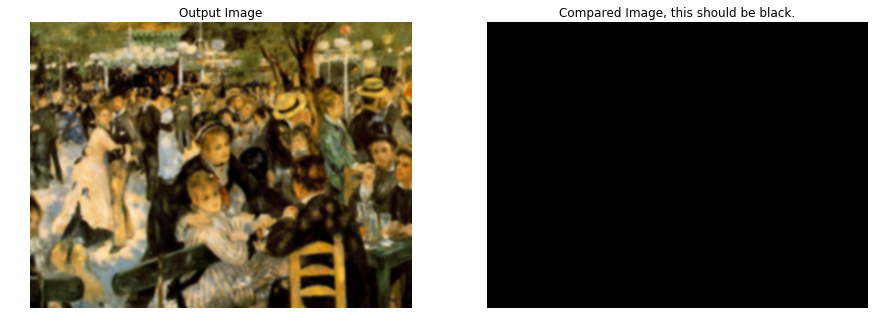

In [7]:
from PIL import Image, ImageChops

point_table = ([0] + ([255] * 255))

def black_or_b(a, b):
    diff = ImageChops.difference(a, b)
    diff = diff.convert('L')
    diff = diff.point(point_table)
    new = diff.convert('RGB')
    new.paste(b, mask=diff)
    return new

a = Image.open('image-out.png')
b = Image.open('image-blured.png')
c = black_or_b(a, b)
c.save('image-diff.png')


fig = plt.figure(figsize=(15,12))

fig.add_subplot(1,2,1)
image = mpimg.imread("image-out.png")
plt.title("Output Image")
plt.axis("off")
plt.imshow(image)

fig.add_subplot(1,2,2)
image1 = mpimg.imread("image-diff.png")
plt.title("Compared Image, this should be black.")
plt.axis("off")
plt.imshow(image1)

plt.show()